In [1]:
import numpy as np

import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
#from astroquery.simbad import Simbad
from tqdm import tqdm
from astropy.coordinates import SkyCoord
#from astroquery.gaia import Gaia
import astropy.units as u
import astropy
from astropy.table import Table
from bisect import bisect_left
import sys

from PyAstronomy import pyasl

halpha = 6564.61
speed_light = 299792458

import lmfit
from scipy.interpolate import interp1d
sys.path.append('../../../wdtools/')
import wdtools
sys.path.append('../../../')
import WD_models
import pickle

import matplotlib
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D

plt.rcParams.update({'font.size': 18})

plt.style.use('vedant')

Bad val "'w'" on line #28
	"figure.facecolor : 'w'
"
	in file "/Users/vedantchandra/.matplotlib/stylelib/vedant.mplstyle"
	Key figure.facecolor: 'w' does not look like a color arg
Using TensorFlow backend.
/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWa

# Skip down to 'Load Data' unless you want to de-redden and fit Balmer parameters again

#### Plot CMD

/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


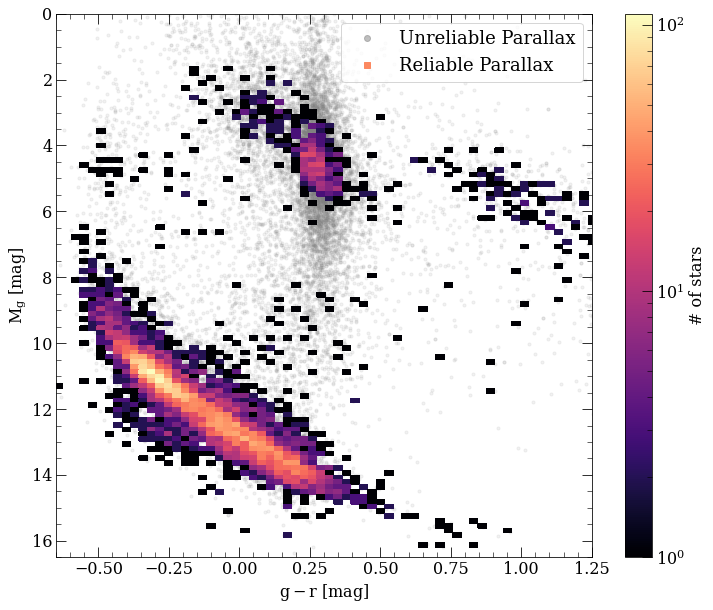

In [2]:
table = Table.read('tables/old_xmatch.fits')

table['g_abs'] = table['g'] + 5 * (np.log10(table['parallax'] / 1000) + 1)
table['g-r'] = table['g'] - table['r']

clean = (
    (table['g-r'] < 2.5)*
    (table['g-r'] > -1)*
    (table['g_abs'] < 18)*
    (table['g_abs'] > -5)*
    (table['g-r'] != 0)
)

goodpar = (
    (table['parallax_over_error'] > 10)
)

plt.figure(figsize = (12, 10))

plt.scatter(table['g-r'][clean], table['g_abs'][clean], s = 10, alpha = 0.1, color = 'gray', rasterized = True)

#plt.scatter(table['g-r'][clean*goodpar], table['g_abs'][clean*goodpar], s = 10, alpha = 0.1, color = 'C2',
#           label = 'Good Astrometry')

plt.hist2d(table['g-r'][clean&goodpar], table['g_abs'][clean&goodpar], bins = 100, 
           norm = matplotlib.colors.LogNorm(),
          cmap = 'magma', rasterized = True);

cmap = plt.cm.magma
custom_lines = [Line2D([0], [0], color = 'gray', linestyle = 'none', marker = 'o', lw = 3, alpha = 0.5), 
                Line2D([0], [0], color = cmap(0.75), linestyle = 'none', marker = 's', lw = 3)]

plt.legend(custom_lines, ['Unreliable Parallax', 'Reliable Parallax'], loc = 1, fontsize = 18)

cbar = plt.colorbar()
cbar.ax.set_ylabel('# of stars')

plt.gca().invert_yaxis()
plt.ylim(16.5, 0)
plt.xlim(-0.65, 1.25)

plt.xlabel('$g - r$ [mag]')
plt.ylabel('$M_{\mathrm{g}}$ [mag]')

plt.savefig('fig/cmd.pdf', bbox_inches = 'tight', rasterized = True, dpi = 300)

#### Get Data

#### De-reddening

#### Get Balmer Parameters

In [3]:
def get_spectrum(source_id):
    path = '../../spec/'+str(source_id)+'_spec_0.fits'
    try:
        with fits.open(path) as f:
            flux = f[1].data['flux']
            loglam = f[1].data['loglam']
            fluxsig = f[1].data['ivar']
            lam = 10**loglam
            f.close()
    except KeyboardInterrupt:
        raise
    except:
        #raise FileNotFoundError('Spectrum file missing...')
        return np.nan, np.nan
    ## RV Correction and Interpolation
    
    return lam, flux

# Load Data

In [3]:
table = Table.read('tables/xmatch_dereddened.fits')

goodpar = (table['parallax_over_error'] > 10) * (table['visibility_periods_used'] > 8) *\
                (table['astrometric_sigma5d_max'] < 1.)
anysda = ['sdA' in i for i in table['ty']]
wd = ['DA' == i for i in table['ty']]

print(len(table))
print(len(table[goodpar]))

14522
1807


/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


In [4]:
mp = 75

phot = (np.array([table[goodpar*anysda][mp]['u_0'], table[goodpar*anysda][mp]['g_0'], 
                   table[goodpar*anysda][mp]['r_0'], table[goodpar*anysda][mp]['i_0'], table[goodpar*anysda][mp]['z_0']]))

print(phot)

wl, fl = get_spectrum(table[goodpar*anysda][mp]['source_id'])
plt.plot(wl, fl)

[17.22844 16.37988 16.1406  16.10408 16.08948]


NameError: name 'get_spectrum' is not defined

In [6]:
spec = np.vstack((wl, fl))
np.savetxt('../test_data/mpms_spec.txt', spec)
np.savetxt('../test_data/mpms_phot.txt', phot)

[18.54944 18.16488 18.1096  18.16808 18.31548]


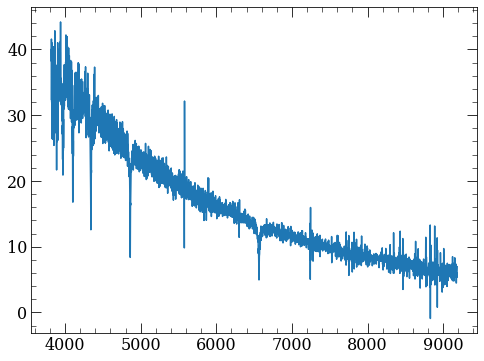

In [7]:
wdi = 31 ## use 26

phot = np.array([table[goodpar*wd][wdi]['u_0'], table[goodpar*wd][wdi]['g_0'], 
                   table[goodpar*wd][wdi]['r_0'], table[goodpar*wd][wdi]['i_0'], table[goodpar*wd][wdi]['z_0']])
print(phot)

wl, fl = get_spectrum(table[goodpar*wd][wdi]['source_id'])

plt.plot(wl, fl)

In [8]:
spec = np.vstack((wl, fl))
np.savetxt('../test_data/wd_spec.txt', spec)
np.savetxt('../test_data/wd_phot.txt', phot)

In [9]:
table[goodpar][1]['source_id']

3797635273107252096

In [5]:
len(table[goodpar*wd]) / len(table[goodpar])

0.659103486441616

In [6]:
len(table[goodpar*anysda]) / len(table[goodpar])

0.3408965135583841

In [7]:
param_df = pd.read_pickle('tables/pdf.p')

In [8]:
pure_sda = (table['ty'] == 'sdA/F') | (table['ty'] == 'DA') | (table['ty'] == 'sdA')

pdf = param_df

clean = (
    (pdf['a_fwhm'] < 75)&
    (pdf['d_fwhm'] < 75)&
    (pdf['g_fwhm'] < 75)&
    (pdf['b_fwhm'] < 75)&
    (pdf['a_height'] < 1)&
    (pdf['b_height'] < 1)&
    (pdf['g_height'] < 1)&
    (pdf['d_height'] < 1)
) & goodpar & pure_sda

wd = np.asarray(wd)

#cleantable = table
cleantable = table[np.asarray(clean)]

phot_X = np.array([cleantable['u_0'], cleantable['g_0'], 
                   cleantable['r_0'], cleantable['i_0'], cleantable['z_0']]).T
raw_phot = phot_X

colors = [];
ncols = phot_X.shape[1]
for i in range(ncols):
    for j in np.arange(i+1, ncols):
        colors.append(phot_X[:, i] - phot_X[:, j])
phot_X = np.array(colors).T

phot_X_griz = np.array([cleantable['g_0'], cleantable['r_0'], cleantable['i_0'], cleantable['z_0']]).T

colors = [];
ncols = phot_X_griz.shape[1]
for i in range(ncols):
    for j in np.arange(i+1, ncols):
        colors.append(phot_X_griz[:, i] - phot_X_griz[:, j])
phot_X_griz = np.array(colors).T


spec_features = ['a_fwhm', 'a_height',
       'b_fwhm', 'b_height',
       'g_fwhm', 'g_height',
         'd_fwhm', 'd_height']

spec_X = pdf[clean][spec_features]
labels = np.zeros(len(wd))
labels[anysda] = 1
t = labels[clean]

X_combined = np.hstack((phot_X, spec_X))

In [9]:
all_features = ['Su', 'Sg', 'Sr', 'Si', 'Sz']
all_features.extend(spec_features)

dd_grid = pd.DataFrame(np.hstack((raw_phot, spec_X)), columns = all_features)

In [10]:
dd_grid['is_mpms'] = t.astype(int)

In [11]:
dd_grid.to_csv('../dd_grid.csv')

In [12]:
dd_grid

,Su,Sg,Sr,Si,Sz,a_fwhm,a_height,b_fwhm,b_height,g_fwhm,g_height,d_fwhm,d_height,is_mpms
0,18.91449,18.63373,18.71035,18.89118,19.06933,63.615599,0.375522,42.746607,0.477282,30.499026,0.566023,25.617476,0.520525,0
1,16.18600,15.28400,15.12000,15.11500,15.12900,12.135270,0.389924,11.740363,0.455176,11.050991,0.491845,12.799737,0.496965,1
2,19.66900,19.12900,18.94300,18.92500,18.89700,27.481479,0.370908,7.332038,0.420667,6.212082,0.563779,7.833827,0.355244,0
3,15.64200,14.66500,14.43100,14.32900,14.36100,7.658818,0.407160,9.059110,0.443140,7.756302,0.469873,8.848705,0.474437,1
4,18.93400,18.51200,18.43700,18.44000,18.53500,36.068392,0.274085,18.210260,0.301266,18.447287,0.359922,12.853983,0.365384,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1692,18.78400,18.42000,18.36800,18.40100,18.46200,28.997769,0.432152,21.716151,0.449911,15.009310,0.527559,18.512759,0.378136,0
1693,18.00300,17.61600,17.59700,17.64900,17.79500,30.726231,0.451661,23.894909,0.510891,18.631708,0.516738,19.154556,0.472451,0
1694,18.80900,18.36900,18.31700,18.35500,18.43800,21.965562,0.529121,15.920101,0.502238,17.115929,0.426385,14.339056,0.488606,0
1695,19.01288,18.69476,18.68420,18.77116,18.98796,30.139118,0.419654,15.077513,0.539753,13.654690,0.524207,13.649188,0.452910,0


## Get Classifiers

In [13]:
from sklearn.metrics import roc_curve, auc, confusion_matrix,precision_recall_curve, average_precision_score

lr_spec = pickle.load(open('LR/spec_lr.p', 'rb'))
lr_phot = pickle.load(open('LR/phot_lr.p', 'rb'))
lr_phot_griz = pickle.load(open('LR/phot_lr_griz.p', 'rb'))
lr_combined = pickle.load(open('LR/combined.p', 'rb'))

In [14]:
prob_spec = lr_spec.predict_proba(spec_X)[:, 1]
prob_phot = lr_phot.predict_proba(phot_X)[:, 1]
prob_phot_griz = lr_phot_griz.predict_proba(phot_X_griz)[:, 1]
prob_combined = lr_combined.predict_proba(X_combined)[:, 1]

spec_fpr, spec_tpr, _ = roc_curve(t, prob_spec)
phot_fpr, phot_tpr, _ = roc_curve(t, prob_phot)
griz_fpr, griz_tpr, _, = roc_curve(t, prob_phot_griz)

combined_fpr, combined_tpr, _ = roc_curve(t, prob_combined)

## ROC Curve

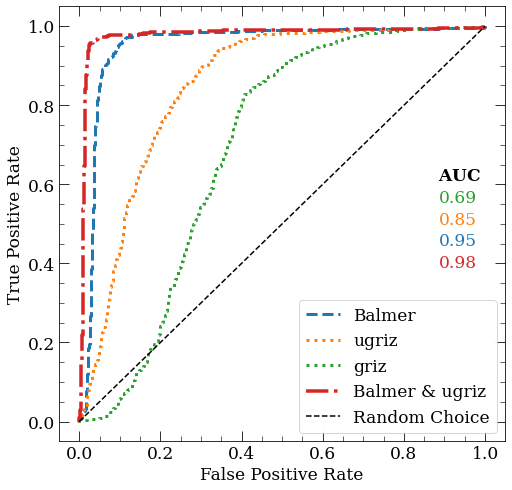

In [16]:
plt.rcParams.update({'font.size': 17})

plt.figure(figsize = (8,8))
c1 = 'C0'
c2 = 'C1'
c3 = 'C2'
c4 = 'C3'

plt.plot(spec_fpr, spec_tpr, label = 'Balmer', color = c1, linestyle = '--', linewidth = 3)
plt.plot(phot_fpr, phot_tpr, label = 'ugriz', color = c2, linestyle = ':', linewidth = 3)
plt.plot(griz_fpr, griz_tpr, label = 'griz', color = c3, linestyle = ':', linewidth = 3)
plt.plot(combined_fpr, combined_tpr, label = 'Balmer & ugriz', color = c4, linestyle = '-.', linewidth = 3.5)

x = np.linspace(0, 1, 100)
plt.plot(x, x, linestyle = '--', color = 'k', label = 'Random Choice')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

vdist = 0
plt.text(0.85, 0.6+vdist, r'$\bf{AUC}$', transform = plt.gca().transAxes)
plt.text(0.85, 0.55+vdist, '%.2f' % auc(griz_fpr, griz_tpr), transform = plt.gca().transAxes, color = c3)
plt.text(0.85, 0.5+vdist, '%.2f' % auc(phot_fpr, phot_tpr), transform = plt.gca().transAxes, color = c2)
plt.text(0.85, 0.45+vdist, '%.2f' % auc(spec_fpr, spec_tpr), transform = plt.gca().transAxes, color = c1)
plt.text(0.85, 0.4+vdist, '%.2f' % auc(combined_fpr, combined_tpr), transform = plt.gca().transAxes, color = c4)

perf_x = [0, 0, 1]
perf_y = [0, 1, 1]

#plt.plot(perf_x, perf_y, color = 'k', label = 'Perfect Classifier')

plt.legend()

plt.savefig('fig/lr_auc.pdf', bbox_inches = 'tight')

## PR Curve

In [17]:
spec_precision, spec_recall, _ = precision_recall_curve(t, prob_spec)
phot_precision, phot_recall, _ = precision_recall_curve(t, prob_phot)
griz_precision, griz_recall, _ = precision_recall_curve(t, prob_phot_griz)

combined_precision, combined_recall, combined_thresh = precision_recall_curve(t, prob_combined)

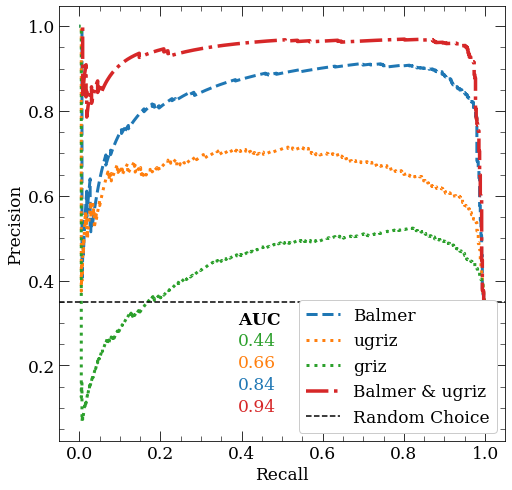

In [19]:
plt.rcParams.update({'font.size': 17})

plt.figure(figsize = (8,8))

plt.plot(spec_recall, spec_precision, label = 'Balmer', color = c1, linestyle = '--', linewidth = 3)
plt.plot(phot_recall, phot_precision, label = 'ugriz', color = c2, linestyle = ':', linewidth = 3)
plt.plot(griz_recall, griz_precision, label = 'griz', color = c3, linestyle = ':', linewidth = 3)
plt.plot(combined_recall, combined_precision, 
         label = 'Balmer & ugriz', color = c4, linestyle = '-.', linewidth = 3.5)

plt.xlabel('Recall')
plt.ylabel('Precision')

vdist = 0.07
plt.text(0.4, 0.2+vdist, r'$\bf{AUC}$', transform = plt.gca().transAxes)
plt.text(0.4, 0.15+vdist, '%.2f' % auc(griz_recall, griz_precision), transform = plt.gca().transAxes, color = c3)
plt.text(0.4, 0.1+vdist, '%.2f' % auc(phot_recall, phot_precision), transform = plt.gca().transAxes, color = c2)
plt.text(0.4, 0.05+vdist, '%.2f' % auc(spec_recall, spec_precision), transform = plt.gca().transAxes, color = c1)
plt.text(0.4, 0.0+vdist, '%.2f' % auc(combined_recall, combined_precision), 
         transform = plt.gca().transAxes, color = c4)

ratio = sum(t) / len(t)
plt.axhline(ratio, color = 'k', linestyle = '--', label = 'Random Choice')

plt.legend(loc = 4, framealpha = 1)

plt.savefig('fig/lr_pr.pdf', bbox_inches = 'tight')

## Apply to all stars and write classifications

In [20]:
clean = (
    (pdf['a_fwhm'] < 100)&
    (pdf['d_fwhm'] < 100)&
    (pdf['g_fwhm'] < 100)&
    (pdf['b_fwhm'] < 100)&
    (pdf['a_height'] < 1)&
    (pdf['b_height'] < 1)&
    (pdf['g_height'] < 1)&
    (pdf['d_height'] < 1)
) & pure_sda

sum(clean)

13378

In [21]:
cleantable = table[np.asarray(clean)]

phot_X = np.array([cleantable['u_0'], cleantable['g_0'], cleantable['r_0'], 
                   cleantable['i_0'], cleantable['z_0']]).T


colors = [];
ncols = phot_X.shape[1]
for i in range(ncols):
    for j in np.arange(i+1, ncols):
        colors.append(phot_X[:, i] - phot_X[:, j])
phot_X = np.array(colors).T

spec_X = pdf[clean][spec_features]

combined_X = np.hstack((phot_X, spec_X))

labels = np.zeros(len(wd))
labels[anysda] = 1
t = labels[clean]

In [22]:
prob_phot = lr_phot.predict_proba(phot_X)[:, 1]
prob_spec = lr_spec.predict_proba(spec_X)[:, 1]
prob_combined = lr_combined.predict_proba(combined_X)[:, 1]

cleantable['p_phot'] = prob_phot
cleantable['p_spec'] = prob_spec
cleantable['p_combined'] = prob_combined

In [25]:
threshold = 0.5
prediction = (prob_combined > threshold).astype(int)

np.sum(prediction == t) / len(t)

0.9404993272537001

(array([1686.,  222.,  142.,   94.,   67.,   76.,   62.,   51.,   47.,
          39.,   42.,   31.,   25.,   40.,   30.,   40.,   36.,   39.,
          56.,   67.,   76.,  103.,  201.,  474., 9632.]),
 array([5.92297369e-23, 4.00000000e-02, 8.00000000e-02, 1.20000000e-01,
        1.60000000e-01, 2.00000000e-01, 2.40000000e-01, 2.80000000e-01,
        3.20000000e-01, 3.60000000e-01, 4.00000000e-01, 4.40000000e-01,
        4.80000000e-01, 5.20000000e-01, 5.60000000e-01, 6.00000000e-01,
        6.40000000e-01, 6.80000000e-01, 7.20000000e-01, 7.60000000e-01,
        8.00000000e-01, 8.40000000e-01, 8.80000000e-01, 9.20000000e-01,
        9.60000000e-01, 1.00000000e+00]),
 <a list of 25 Patch objects>)

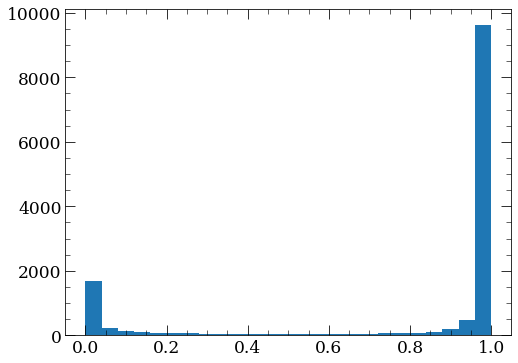

In [26]:
plt.hist(prob_combined)

In [27]:
cleantable.write('tables/lr_class.fits', overwrite = True)